In [2]:
import cantera as ct
ct.suppress_thermo_warnings = True
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Design project : Replacing $CH_4$ with $(NH_3 + H_2)$ in gas turbines

## 1. Design of the $CH_4$ gas turbine

### 1.1 Initial $CH_4$ gas turbine configuration

- Low $NO_x$ $CH_4$ gas turbines normally operate at lean equivalence ratios, such as $\phi = 0.45$ [1].

- Reactants are normally pre-heated at around 750K in $CH_4$ gas turbines [1]. 

- Due to the lower heating value of $NH_3 + H_2$, a high volumetric flow is needed and such is associated with a power output of at least 2 MW [2]. We choose for our gas turbine to operate with a power output of 5 MW.

- Gas turbines typically operate at high pressures, we choose for our gas turbine to operate at 5 atm, as higher pressure are also correlated with less pollutants emissions in ammonia combustion [3].

## 2. $CH_4$ flame properties

- Now that we know our gas turbine configuration, we compute the $CH_4$ flame parameters to match them with the $NH_3 / H_2$ blend

### 2.1 $CH_4$ adiabatic flame temperature

- Only considering $\phi = 0.45$

In [11]:
gas = ct.Solution('gri30.yaml')
gas.set_equivalence_ratio(0.45, {'CH4':1.0}, {'O2':0.21, 'N2':0.79})
Tin, Pin = 750, 5*ct.one_atm
gas.TP = Tin, Pin
gas.equilibrate('HP')
print('CH4 adiabatic flame temperature :', np.around(gas.T), 'K')

CH4 adiabatic flame temperature : 1748.0 K


### 2.2 $CH_4$ laminar flame speed

With : 

- $\phi = 0.45$
- $T_{in} = 750 \; K$
- $P_{in} = 5 \; atm$

In [12]:
gas = ct.Solution('gri30.yaml')
gas.set_equivalence_ratio(0.45, {'CH4':1.0}, {'O2':0.21, 'N2':0.79})
Tin = 750
Pin = 5*ct.one_atm
gas.TP = Tin, Pin
width = 0.5

flame = ct.FreeFlame(gas, width=width)
flame.set_refine_criteria(ratio=3, slope=0.1, curve=0.1)
flame.solve(loglevel=0, auto=True)

print('CH4 laminar flame speed = ', flame.velocity[0], 'm/s')

CH4 laminar flame speed =  0.2561931024834376 m/s


### 2.3 Thermal flame thickness

With the same flame configuration

In [13]:
Tu = flame.T[0]
Tb = flame.T[-1]
lf = (Tb - Tu) / np.max(np.gradient(flame.T, flame.grid))
print('Thermal flame thickness : ', np.around(lf*1000,3), 'mm')

Thermal flame thickness :  0.253 mm


## 3. $NH_3 + H_2$ blend with the same properties

- Ammonia can be cracked at relatively low temperature according to the following reaction : 

$NH_3 \rightarrow 0.5 N_2 + 1.5 H_2 $

- In a gas turbine application this means that any specific $H_2$ volume fraction can be used

- To replace $CH_4$ we find the $H_2$ volume fraction with the most similar flame properties

### 3.1 Adiabatic flame temperature of $NH_3 + H_2$ flames with varying $X(H_2)$

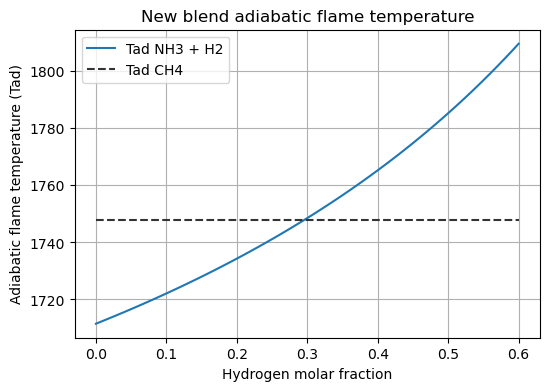

In [33]:
gas = ct.Solution('NH3_Xiao.yaml')
Tin, Pin = 750, 5*ct.one_atm
ch4_data = {'Tad':1748.0, 'Su':0.25619, 'lf':0.253}
H2_values = np.arange(0, 0.61, 0.01)
air = {'O2':0.21, 'N2':0.79}
Tad_values = []

for X_h2 in H2_values:
    X_n2 = X_h2/3
    X_nh = 1 - X_h2 - X_n2
    fuel = {'NH3':X_nh, 'N2':X_n2, 'H2':X_h2}
    gas.set_equivalence_ratio(0.45, fuel, air)
    gas.TP = Tin, Pin
    gas.equilibrate('HP')
    Tad_values.append(gas.T)

fig, ax = plt.subplots(figsize=(6, 4))
    
ax.plot(H2_values, Tad_values, label='Tad NH3 + H2')
ax.plot([H2_values[0], H2_values[-1]], [ch4_data['Tad'], ch4_data['Tad']], color='0.2', linestyle='--', label='Tad CH4')

ax.set_ylabel('Adiabatic flame temperature (Tad)')
ax.set_xlabel('Hydrogen molar fraction')
ax.set_title('New blend adiabatic flame temperature')
ax.grid()
ax.legend()

### 3.2 Flame speed of $NH_3 + H_2$ flames with varying $X(H_2)$

In [40]:
# This takes a while (like 5-6 min)
gas = ct.Solution('NH3_Xiao.yaml')
Tin, Pin = 750, 5*ct.one_atm
width = 0.5
ch4_data = {'Tad':1748.0, 'Su':0.25619, 'lf':0.253}
H2_values = np.arange(0, 0.61, 0.05)
air = {'O2':0.21, 'N2':0.79}
Su_values = []
Temp_arrays = []
grid_arrays = []

for i, X_h2 in enumerate(H2_values):
    X_n2 = X_h2/3
    X_nh = 1 - X_h2 - X_n2
    fuel = {'NH3':X_nh, 'N2':X_n2, 'H2':X_h2}
    gas.set_equivalence_ratio(0.45, fuel, air)
    gas.TP = Tin, Pin
    Tad_values.append(gas.T)
    flame = ct.FreeFlame(gas, width=width)
    flame.set_refine_criteria(ratio=3, slope=0.1, curve=0.1)
    flame.solve(loglevel=0, auto=True)
    Temp_arrays.append(flame.T)
    grid_arrays.append(flame.grid)
    Su_values.append(flame.velocity[0])



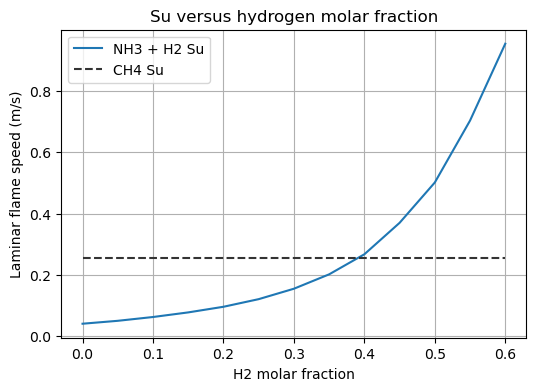

In [41]:
H2_values = np.arange(0, 0.61, 0.05)
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(H2_values, Su_values, label='NH3 + H2 Su')
ax.plot([H2_values[0], H2_values[-1]], [ch4_data['Su'], ch4_data['Su']], 
         color='0.2', linestyle='--', label='CH4 Su')
ax.set_xlabel('H2 molar fraction')
ax.set_ylabel('Laminar flame speed (m/s)')
ax.set_title('Su versus hydrogen molar fraction')
ax.grid()
ax.legend()

### 3.3 Thermal flame thickness of $NH_3 + H_2$ flames with varying $X(H_2)$

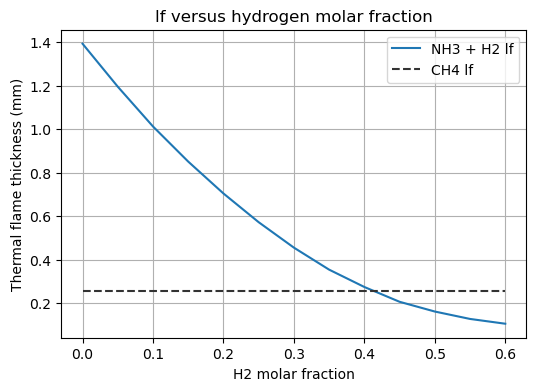

In [42]:
lf_values = []
for Tarr, grid in zip(Temp_arrays, grid_arrays):
    Tu = Tarr[0]
    Tb = Tarr[-1]
    lf = (Tb - Tu) / np.max(np.gradient(Tarr, grid))
    lf_values.append(lf*1000)

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(H2_values, lf_values, label='NH3 + H2 lf')
ax.plot([H2_values[0], H2_values[-1]], [ch4_data['lf'], ch4_data['lf']], 
         color='0.2', linestyle='--', label='CH4 lf')
ax.set_xlabel('H2 molar fraction')
ax.set_ylabel('Thermal flame thickness (mm)')
ax.set_title('lf versus hydrogen molar fraction')
ax.grid()
ax.legend()

### 3.4 $CH_4$ Equivalent $NH_3 + H_2$ fuel blend

- Graphically, it can be seen that in the chosen conditions, a molar fraction $X(H_2) = 0.4$ allows the obtention of similar flame properties compared to $CH_4$

- The chosen fuel blend is then :

$X(H_2) = 0.4$

$X(N_2) = 0.13$ 

$X(NH_3) = 0.47$

## 4. Gas turbine modelling with PSR

### 4.1 $CH_4$ mass flow rate

Here we determine the required mass flow rate in our gas turbine conditions to obtain the desired power output of 5 MW with :

- $H_{CH_4} = 50 MJ/kg$

$\dot{m}_{CH_4} = 5 MW /  50 MJ/kg = 0.1 kg/s $  

### 1.3 inlet mass flow rate

with $\phi = 0.45$ : 

$Y(CH_4) = 0.0256$

$\dot{m} = \dot{m}_{CH_4} / Y(CH_4)$

$\dot{m} = 3.91 kg/s$

$\dot{m}_{air} = 3.91 - 0.1 = 3.81 kg/s$


In [47]:
gas = ct.Solution('gri30.yaml')
gas.set_equivalence_ratio(0.45, {'CH4':1.0}, {'O2':0.21, 'N2':0.79})
print('Y(CH4) = ', gas.Y[gas.species_index('CH4')])

Y(CH4) =  0.02560168035906575


### 4.3 Gas turbine (PSR) with CH4

In [15]:
# Create the solution
gas = ct.Solution('gri30.yaml')

# Define the inlet
gas.TP = 750, 5 * ct.one_atm
fuel = {'CH4':1.0}
air = {'O2':0.21, 'N2':0.79}
gas.set_equivalence_ratio(0.45, fuel, air)
inlet = ct.Reservoir(gas)

# Define the combustor
gas.TP = 1300, 5 * ct.one_atm
combustor = ct.IdealGasReactor(gas)
combustor.volume = 0.4

# Define the exhaust
exhaust = ct.Reservoir(gas)

inlet_mfc = ct.MassFlowController(inlet, combustor, mdot=3.91)
outlet_mfc = ct.PressureController(combustor, exhaust, master=inlet_mfc, K=0.1)

# Simulation and states
sim = ct.ReactorNet([combustor])
states = ct.SolutionArray(gas)
states.append(combustor.thermo.state)

time = 0
while time < 0.1:
    time = sim.step()
    Ti = states.T[-1]
    states.append(combustor.thermo.state)

To = combustor.thermo.state[0]

data = [states.X[:, gas.species_index('CO')][-1]*1e6, states.X[:, gas.species_index('NO')][-1]*1e6]
data = [np.around(di, 1) for di in data]
data.append(np.around(combustor.mass/3.91, 3))
index = [r'$ppm \; CO$', r'$ppm \; NO$', 'residence time (s)']
columns=['']
df = pd.DataFrame(data=data, index=index, columns=columns)
df

,
$ppm \; CO$,80.200
$ppm \; NO$,488.100
residence time (s),0.092


### 4.3 NH3 + H2 mass flow rate

- What is the required $NH_3$ + $H_2$ mass flow inlet to obtain 5 MW ?

Combustion heat values :
- $H_{NH3}$ = 22.47 MJ/kg
- $H_{H2}$ = 141.8 MJ/kg

Mass fractions in the pre-mixed blend : 

- $Y(H2) = 0.00445$ 
- $Y(NH3) = 0.0442$

$\dot{m} Y(H2) H_{H2} + \dot{m} Y(NH3) H_{NH3} = 5MW$

$\dot{m}_{fuel} = 3.08 kg /s $

In [8]:
gas = ct.Solution('NH3_Xiao.yaml')
fuel = {'H2':0.4, 'N2':0.13, 'NH3':0.47}
air = {'N2':0.79, 'O2':0.21}
gas.set_equivalence_ratio(0.45, fuel, air)
print('Y(NH3):', gas.Y[gas.species_index('NH3')])
print('Y(H2):',gas.Y[gas.species_index('H2')])

Y(NH3): 0.04419244906067398
Y(H2): 0.0044520556285381355


In [9]:
mdot_fuel = 5 / (gas.Y[gas.species_index('NH3')] * 22.47 + gas.Y[gas.species_index('H2')] * 141.8)
print('mdot_fuel : ', mdot_fuel)

mdot_fuel :  3.078238065141965


## 4.4 Gas turbine PSR with $NH_3 + H_2$

In [27]:
# Create the solution
gas = ct.Solution('NH3_Xiao.yaml')

# Define the inlet
gas.TP = 750, 5 * ct.one_atm
fuel = {'H2':0.4, 'N2':0.13, 'NH3':0.47}
air = {'O2':0.21, 'N2':0.79}
gas.set_equivalence_ratio(0.45, fuel, air)
inlet = ct.Reservoir(gas)

# Define the combustor
gas.TP = 1300, 5 * ct.one_atm
combustor = ct.IdealGasReactor(gas)
combustor.volume = 0.4

# Define the exhaust
exhaust = ct.Reservoir(gas)

inlet_mfc = ct.MassFlowController(inlet, combustor, mdot=3.08)
outlet_mfc = ct.PressureController(combustor, exhaust, master=inlet_mfc, K=0.1)

# Simulation and states
sim = ct.ReactorNet([combustor])
states = ct.SolutionArray(gas)
states.append(combustor.thermo.state)

time = 0
while time < 0.1:
    time = sim.step()
    Ti = states.T[-1]
    states.append(combustor.thermo.state)

To = combustor.thermo.state[0]

data = [states.X[:, gas.species_index('NH3')][-1]*1e6, 
        states.X[:, gas.species_index('NO')][-1]*1e6,
        states.X[:, gas.species_index('H2')][-1]*1e6]
data = [np.around(di, 1) for di in data]
data.append(np.around(combustor.mass/3.08, 3))
index = [r'$ppm \; NH3$', r'$ppm \; NO$', r'$ppm \; H2$','residence time (s)']
columns=['']
df = pd.DataFrame(data=data, index=index, columns=columns)
df

,
$ppm \; NH3$,6.300
$ppm \; NO$,4273.900
$ppm \; H2$,50.200
residence time (s),0.109


- Using the same parameters as for $CH_4$
- We have a similar residence time, no $CO$, almost no $NH_3$, but 10 times more NO formation...

## 4.5 Using a RQL reactor

- Computing the rich mass flow rate

In [33]:
gas = ct.Solution('NH3_Xiao.yaml')
fuel = {'H2':0.4, 'N2':0.13, 'NH3':0.47}
air = {'N2':0.79, 'O2':0.21}
gas.set_equivalence_ratio(1.2, fuel, air)
print('Y(NH3):', gas.Y[gas.species_index('NH3')])
print('Y(H2):',gas.Y[gas.species_index('H2')])

Y(NH3): 0.1057313661737085
Y(H2): 0.010651636962694878


In [34]:
mdot_fuel = 5 / (gas.Y[gas.species_index('NH3')] * 22.47 + gas.Y[gas.species_index('H2')] * 141.8)
print('mdot_fuel : ', mdot_fuel)

mdot_fuel :  1.2866085421323232


## 4.5.1 First stage

In [70]:
# Create the solution
gas = ct.Solution('NH3_Xiao.yaml')

# Define the inlet
gas.TP = 750, 5 * ct.one_atm
fuel = {'H2':0.4, 'N2':0.13, 'NH3':0.47}
air = {'O2':0.21, 'N2':0.79}
gas.set_equivalence_ratio(1.2, fuel, air)
inlet = ct.Reservoir(gas)
mdot = 1.2866085421323232

# Define the combustor
gas.TP = 1000, 5 * ct.one_atm
combustor = ct.IdealGasReactor(gas)
combustor.volume = 0.5

# Define the exhaust
exhaust = ct.Reservoir(gas)

inlet_mfc = ct.MassFlowController(inlet, combustor, mdot=mdot)
outlet_mfc = ct.PressureController(combustor, exhaust, master=inlet_mfc, K=0.1)

# Simulation and states
sim = ct.ReactorNet([combustor])
states = ct.SolutionArray(gas)
states.append(combustor.thermo.state)

time = 0
while time < 0.1:
    time = sim.step()
    Ti = states.T[-1]
    states.append(combustor.thermo.state)

data = [states.X[:, gas.species_index('NH3')][-1]*1e6, 
        states.X[:, gas.species_index('NO')][-1]*1e6,
        states.X[:, gas.species_index('H2')][-1]*1e6]
data.append(states.T[-1])
data.append(gas.equivalence_ratio(fuel, air))
data = [np.around(di, 1) for di in data]
data.append(np.around(combustor.mass/mdot, 3))
index = [r'$ppm \; NH3$', r'$ppm \; NO$', r'$ppm \; H2$', 'Temperature (K)', r'$\phi$', 'residence time (s)']
columns=['']
df = pd.DataFrame(data=data, index=index, columns=columns)
df

,
$ppm \; NH3$,5.600
$ppm \; NO$,1448.900
$ppm \; H2$,59121.600
Temperature (K),2466.100
$\phi$,1.200
residence time (s),0.226


### 4.5.2 Second stage

- Quench the exhaust with cold air

In [86]:
gas_a = ct.Solution('air.yaml')
gas_a.TP = 300, 5 * ct.one_atm
gas_a.X = air
rho_a = gas_a.density

gas_b = gas
rho_b = gas_b.density

res_a = ct.Reservoir(gas_a)
res_b = ct.Reservoir(gas_b)
downstream = ct.Reservoir(gas_b)

# Create a reactor for the mixer. A reactor is required instead of a
# reservoir, since the state will change with time if the inlet mass flow
# rates change or if there is chemistry occurring.
gas_c = ct.Solution('NH3_Xiao.yaml')
gas_c.TPX = 300.0, ct.one_atm, 'O2:0.21, N2:0.79'
mixer = ct.IdealGasReactor(gas_c)

# stoichiometric combustion.
mfc1 = ct.MassFlowController(res_a, mixer, mdot=(3.08 - mdot))
mfc2 = ct.MassFlowController(res_b, mixer, mdot=mdot)

# connect the mixer to the downstream reservoir with a valve.
outlet = ct.Valve(mixer, downstream, K=10.0)

sim = ct.ReactorNet([mixer])

# Since the mixer is a reactor, we need to integrate in time to reach steady
# state
sim.advance_to_steady_state()

# view the state of the gas in the mixer

data = [mixer.thermo.X[gas.species_index('NH3')]*1e6, 
        mixer.thermo.X[gas.species_index('NO')]*1e6,
        mixer.thermo.X[gas.species_index('H2')]*1e6]

diff = 0.15 - mixer.thermo.X[gas.species_index('O2')]
scale = 1 - diff
data.append(data[1] *  scale)
data.append(mixer.T)
data = [np.around(di, 1) for di in data]
data.append(np.around(gas_c.equivalence_ratio(fuel, air), 2))
index = [r'$ppm \; NH3$', r'$ppm \; NO$', r'$ppm \; H2$', 'ppmv NO (CEPA)', 'Temperature (K)', r'$\phi$']
columns=['']
df = pd.DataFrame(data=data, index=index, columns=columns)
df

,
$ppm \; NH3$,0.00
$ppm \; NO$,686.00
$ppm \; H2$,6.00
ppmv NO (CEPA),651.30
Temperature (K),1634.40
$\phi$,0.45


- Using a two stage combustor we reach NO concentration similar to CH4 use case
- We can impose the same overall equivalence ratio
- There is no CO emission
- This unrefined case still has NO emission one order of magnitude above the canadian standard [4], but simililarities to the concentration for CH4 shows that relatively low NO emissions values for NH3 combustion are possible

## References 

[1] S. Wiseman, M. Rieth, A. Gruber, J. R. Dawson, and J. H. Chen, “A comparison of the blow-out behavior of turbulent premixed ammonia/hydrogen/nitrogen-air and methane–air flames,” Proceedings of the Combustion Institute, vol. 38, no. 2, pp. 2869–2876, 2021, doi: 10.1016/j.proci.2020.07.011.

[2] K. D. K. A. Somarathne et al., “Emission characteristics of turbulent non-premixed ammonia/air and methane/air swirl flames through a rich-lean combustor under various wall thermal boundary conditions at high pressure,” Combustion and Flame, vol. 210, pp. 247–261, Dec. 2019, doi: 10.1016/j.combustflame.2019.08.037.

[3] K. D. K. A. Somarathne, S. Hatakeyama, A. Hayakawa, and H. Kobayashi, “Numerical study of a low emission gas turbine like combustor for turbulent ammonia/air premixed swirl flames with a secondary air injection at high pressure,” International Journal of Hydrogen Energy, vol. 42, no. 44, pp. 27388–27399, Nov. 2017, doi: 10.1016/j.ijhydene.2017.09.089.

[4] E. and C. C. Canada, “Reducing nitrogen oxide emissions from natural gas-fuelled stationary combustion turbines: guidelines,” Nov. 17, 2017. https://www.canada.ca/en/environment-climate-change/services/canadian-environmental-protection-act-registry/guidelines-objectives-codes-practice/reduction-nitrogen-oxide-combustion-turbines-guidelines.html (accessed Nov. 16, 2022).


